<html>
    <div style="padding: 50px; background-color: lightskyblue; text-align: center; color: #000;">
        <h1>CAB420 Workshop - Week 3 Practical</h1>
        <h2>Classification</h2>
    </div>
</html>

In [200]:
# Loading in relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from scipy.stats import norm

Creating a large value for infinity

In [201]:
inf = 1e250

Function used to generate the confusion matrix

In [202]:
def generate_figures(model, num_figures, X_values, Y_values, titles):    
    fig = plt.figure(figsize = (20, 10))
    
    if num_figures != len(titles):
        raise ValueError('The number of titles must be equal to the number of figures')
    
    if isinstance(model, list):
        model_length = len(model)
        
        k = 0
        for i in range(num_figures):
            if i >= model_length and k + 1 != 2:
                k += 1

            ax = fig.add_subplot(model_length, model_length, i + 1)
            conf_matrix = ConfusionMatrixDisplay.from_estimator(model[k], X_values[i], Y_values[i], normalize = 'true', ax = ax)
            conf_matrix.ax_.set_title(titles[i])
    else:
        for i in range(num_figures):
            ax = fig.add_subplot(1, num_figures, i + 1)
            conf_matrix = ConfusionMatrixDisplay.from_estimator(model, X_values[i], Y_values[i], normalize = 'true', ax = ax)
            conf_matrix.ax_.set_title(titles[i])

    return fig, ax

## Problem 1 - Binary Classification

Consider the data set redwine-binary.csv. This data contains both objective measurements on chemical and physical properties of the red wines, and subjective measurements of quality based on expert judegments. In this data, wine quality is the response variable and is either "above average" (1) or "below average" (0) Using this data set:

1. Fit a Support Vector Machine to the data, and select appropriate values of C and an appropriate kernel to maximise accuracy. 

2. Fit a K-Nearest Neighbours Classifier to the data, and select appropriate values of K and the distance metric to maximise accuracy.

For both models, repeat your experiments with and without standardising the data, and note any differences in performance. 

### Step 1: Data Loading and Splitting

Here you need to:
* Load the data, I'd suggest pandas and ``read_csv()`` as we've uesd elsewhere
* Pull out X and Y data. Your Y values are the ``quality`` data series
* Split the data into train and test. I'd suggest ``train_test_split`` from ``sklearn.model_selection``, which will split the data into two sets (i.e. split all data into train and test). If you wish to get three datasets (train, validation, and test), then:
  * Split the data into train and "the rest", using say a 70/30 split
  * Split "the rest" into validation and test, using a 50/50 split  

In [203]:
# Loading the data and showing the first few rows of the binary data
redwine_binary = pd.read_csv('data/redwine-binary.csv')
redwine_multiclass = pd.read_csv('data/redwine-multiclass.csv')

redwine_binary.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [204]:
# Splitting the data initially into X and Y
Y = redwine_binary['quality']
X = redwine_binary.drop(columns = ['quality'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

test_length = len(Y_test)

X_val = X_test[:test_length // 2]
X_test = X_test[test_length // 2:]

Y_val = Y_test[:test_length // 2]
Y_test = Y_test[test_length // 2:]

### Step 1b: Standardisation

To standardise, or not to standardise?

Use a box plot to visualise the scale of the different dimensions in the X data. Focus on the training set. The question asks you to explore performance both with and without standardisation, which you can do simply by commenting out standardistaion code which could go about here.

Remember with your standardisation, you should compute the mean and standard deviation on the training set, and then use that mean and standard deviation to standardise your training, (validation? if you have it,) and testing sets.

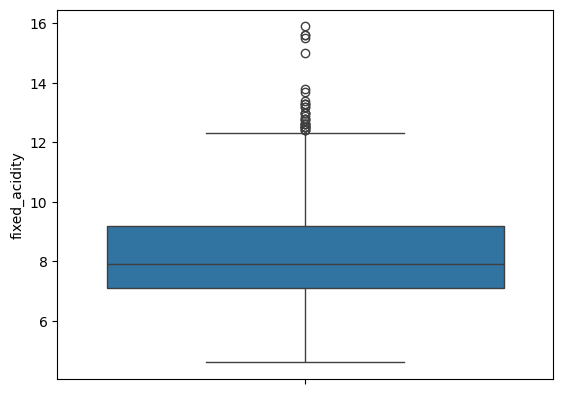

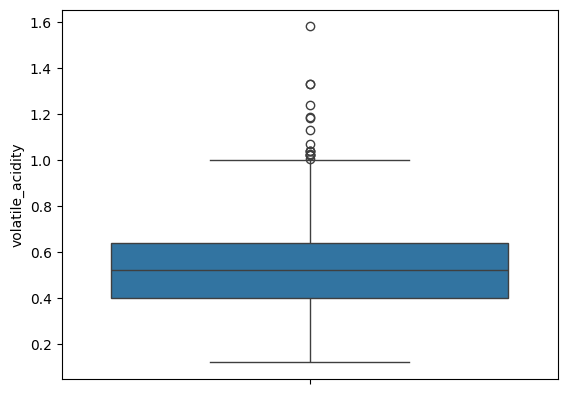

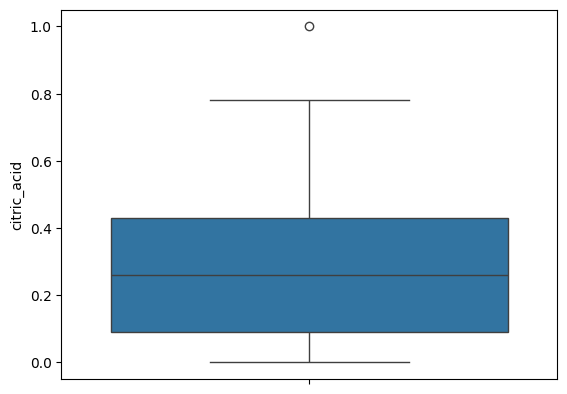

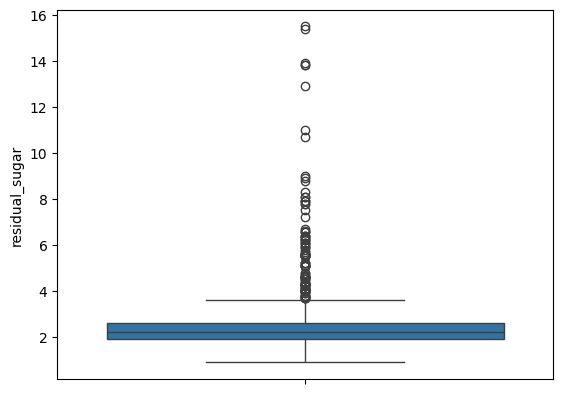

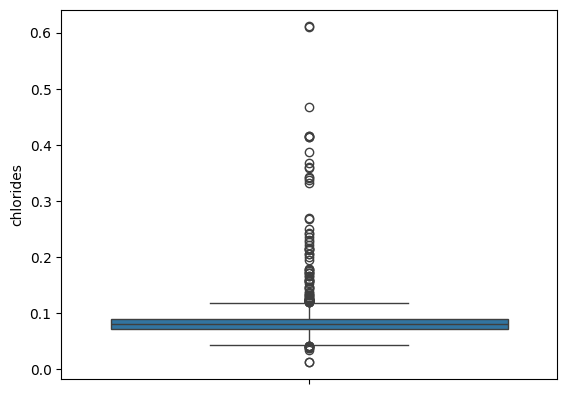

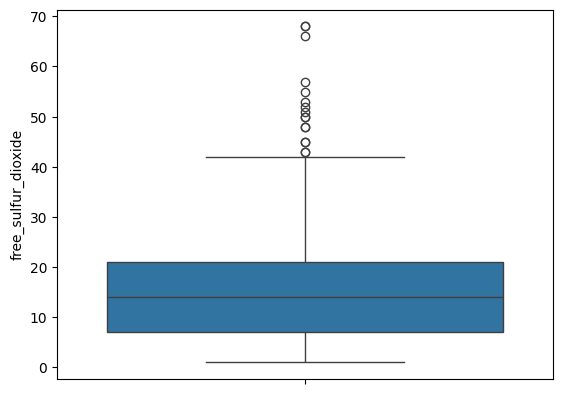

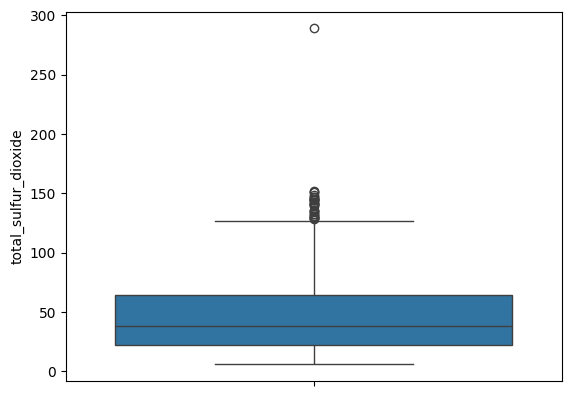

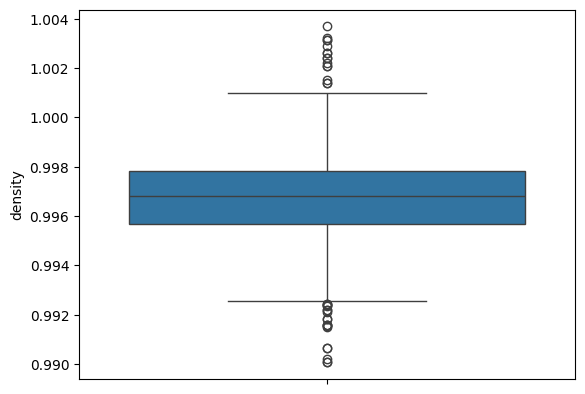

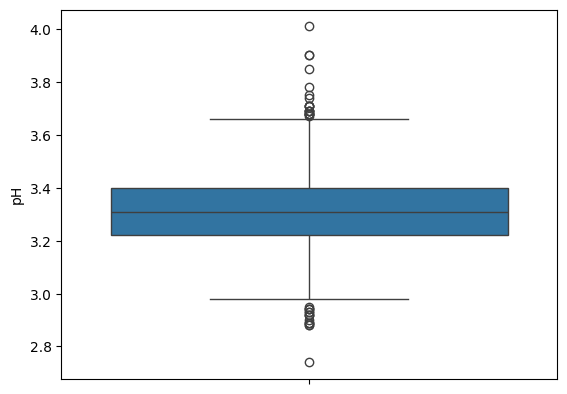

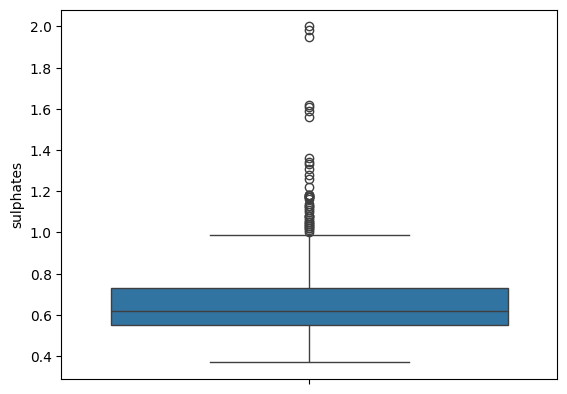

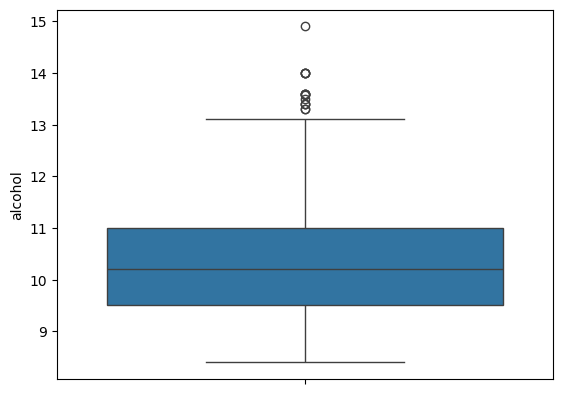

In [205]:
for variable in X_train.columns:
    sns.boxplot(y = X_train[variable])
    plt.show()

Completing the standardisation

In [206]:
mu = np.mean(X_train, 0)
sigma = np.std(X_train, 0)

X_standardised = (X - mu) / sigma

X_train_standardised, X_test_standardised, Y_train_standardised, Y_test_standardised = train_test_split(X_standardised, Y, test_size = 0.3, random_state = 42)

### Step 2: Fitting Models

Here you need to:
* Fit an SVM, and explore parameter choices. In particular focus on what happens as you change C, the kernel, and kernel parameters ($\gamma$ with an RBF kernel, the polynomial order with a polynomial kernal). Parameter choices can be explored either by:
  * Simple trial and error
  * A grid search, or similar automated search method. Look at ``CAB420_Classification_Example_1_Classification_Three_Ways.ipynb`` for an example of how to use such methods. More information is also available in the [sklearn documentation](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)
* Fit a CKNN, once again exploring parameter choices. In particular focus on K, and the distance measure chosen. You may also wish to experiment with the distance weighting scheme used. Again, either trial and error or a grid search (or similar) is a good choice here.

An evaluation function is provided below, based on what is used in the lecture examples.

### Fitting the SVM Model

In [207]:
svm_model = SVC(C = 1, kernel = 'linear', random_state = 42)
svm_model.fit(X_train, Y_train)

SVC(C=1, kernel='linear', random_state=42)

### Fitting the K Nearest Neighbours Model

In [208]:
cknn_model = KNeighborsClassifier(n_neighbors = 10, weights = 'uniform')
cknn_model.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=10)

### Running Visualisations
SVM Model

(<Figure size 2000x1000 with 4 Axes>,
 <Axes: title={'center': 'Testing Data'}, xlabel='Predicted label', ylabel='True label'>)

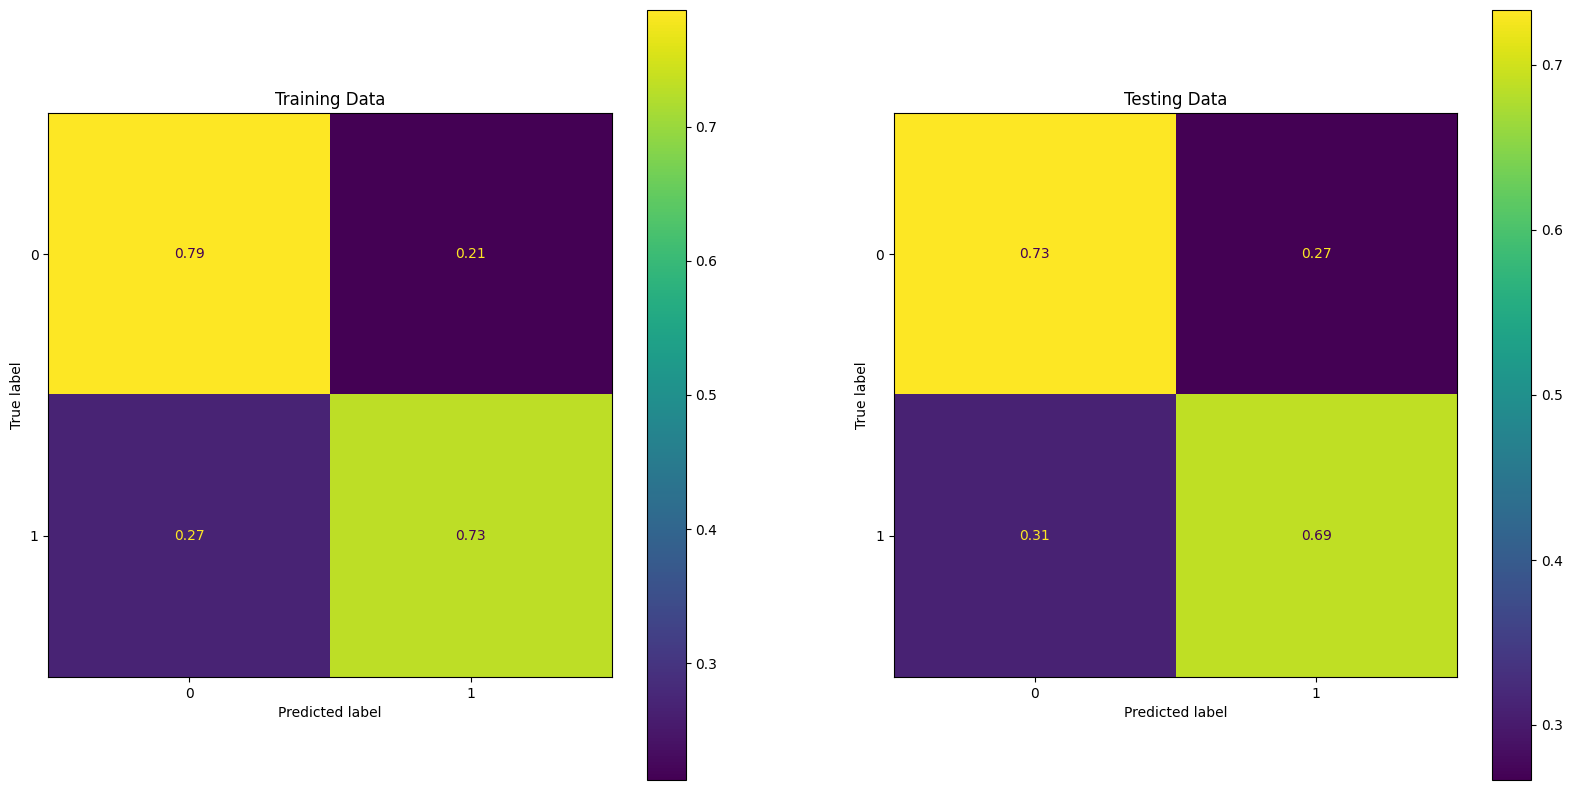

In [209]:
svm_model_titles = [
    'Training Data',
    'Testing Data'
]

generate_figures(svm_model, 2, [X_train, X_test], [Y_train, Y_test], svm_model_titles)

K-Nearest Neighbours Model

(<Figure size 2000x1000 with 4 Axes>,
 <Axes: title={'center': 'Testing Data'}, xlabel='Predicted label', ylabel='True label'>)

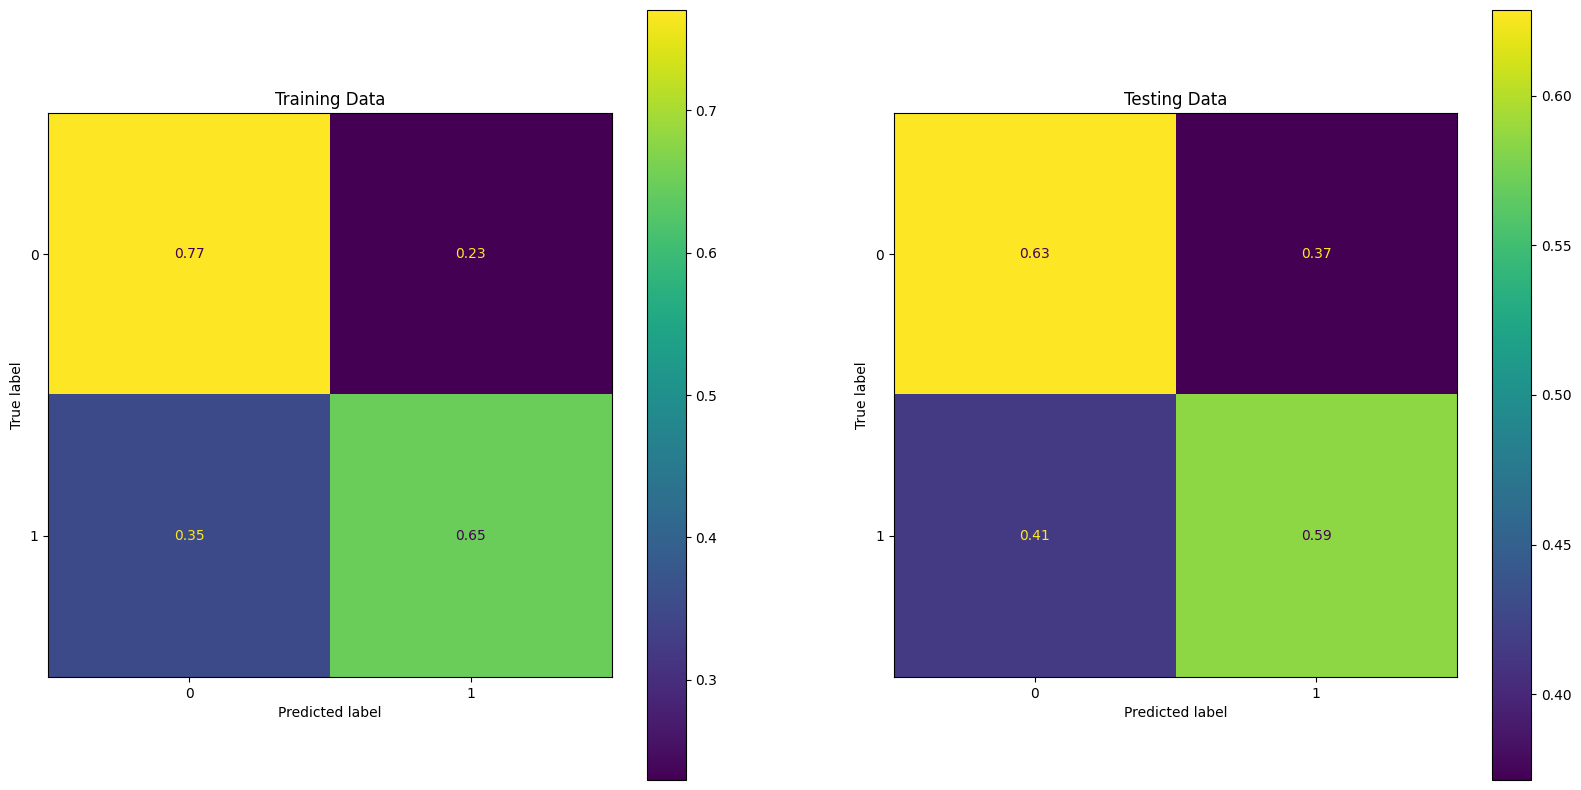

In [210]:
generate_figures(cknn_model, 2, [X_train, X_test], [Y_train, Y_test], svm_model_titles)

### Testing Model Performance after Standardisation
SVM Model

In [211]:
svm_model_standardised = SVC(C = 1, kernel = 'linear', random_state = 42)
svm_model_standardised.fit(X_train_standardised, Y_train_standardised)

SVC(C=1, kernel='linear', random_state=42)

K-Nearest Neighbours

In [212]:
cknn_model_standardised = KNeighborsClassifier(n_neighbors = 10, weights = 'uniform')
cknn_model_standardised.fit(X_train_standardised, Y_train_standardised)

KNeighborsClassifier(n_neighbors=10)

### Running Visualisations
SVM Model

(<Figure size 2000x1000 with 8 Axes>,
 <Axes: title={'center': 'Testing Data (Post Standardisation)'}, xlabel='Predicted label', ylabel='True label'>)

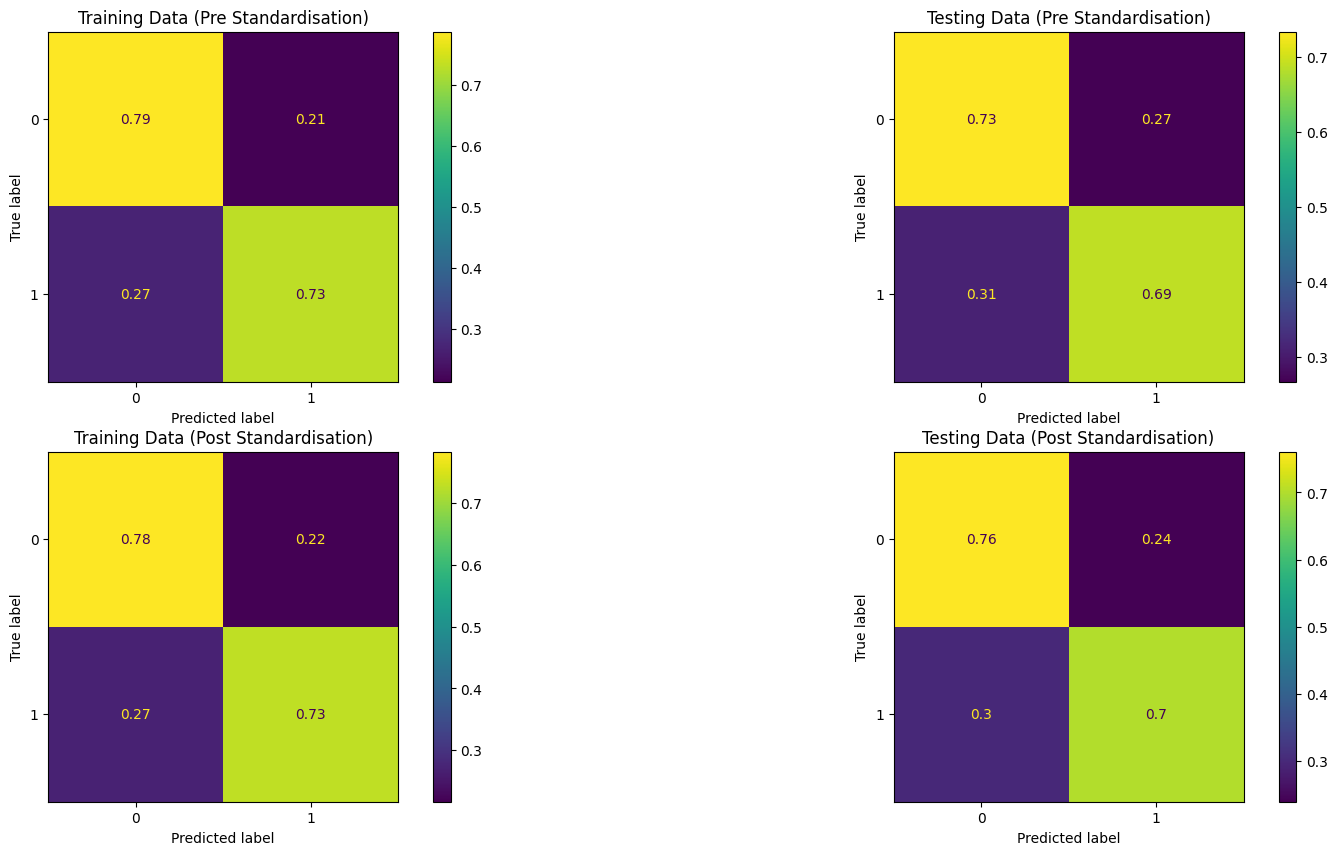

In [213]:
standardisation_figure_titles = [
    'Training Data (Pre Standardisation)',
    'Testing Data (Pre Standardisation)',
    'Training Data (Post Standardisation)',
    'Testing Data (Post Standardisation)'
]

generate_figures([svm_model, svm_model_standardised], 4, [X_train, X_test, X_train_standardised, X_test_standardised], [Y_train, Y_test, Y_train_standardised, Y_test_standardised], standardisation_figure_titles)

K-Nearest Neighbours Model

(<Figure size 2000x1000 with 8 Axes>,
 <Axes: title={'center': 'Testing Data (Post Standardisation)'}, xlabel='Predicted label', ylabel='True label'>)

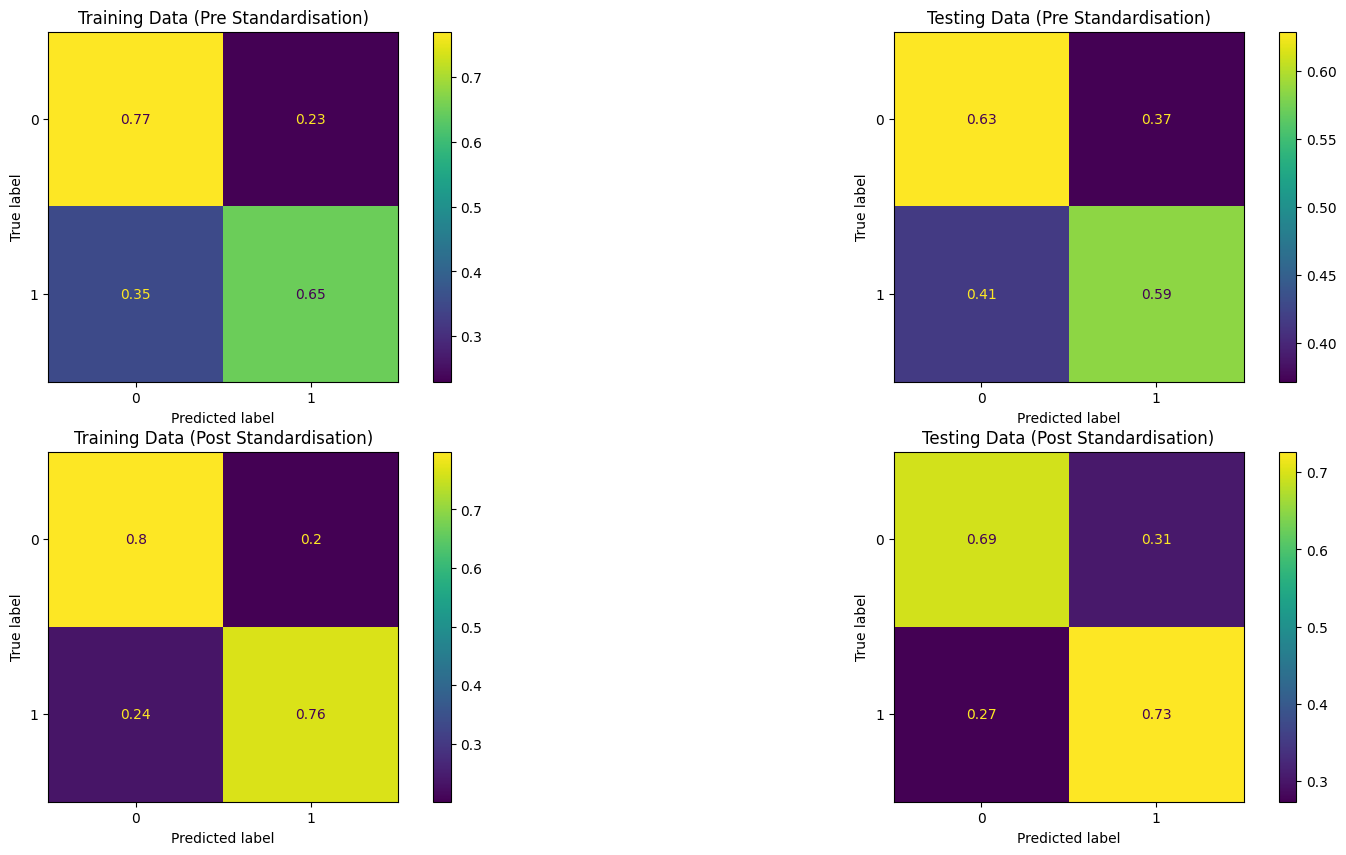

In [214]:
generate_figures([cknn_model, cknn_model_standardised], 4, [X_train, X_test, X_train_standardised, X_test_standardised], [Y_train, Y_test, Y_train_standardised, Y_test_standardised], standardisation_figure_titles)

(<Figure size 2000x1000 with 8 Axes>,
 <Axes: title={'center': 'Testing Data (Post Standardisation)'}, xlabel='Predicted label', ylabel='True label'>)

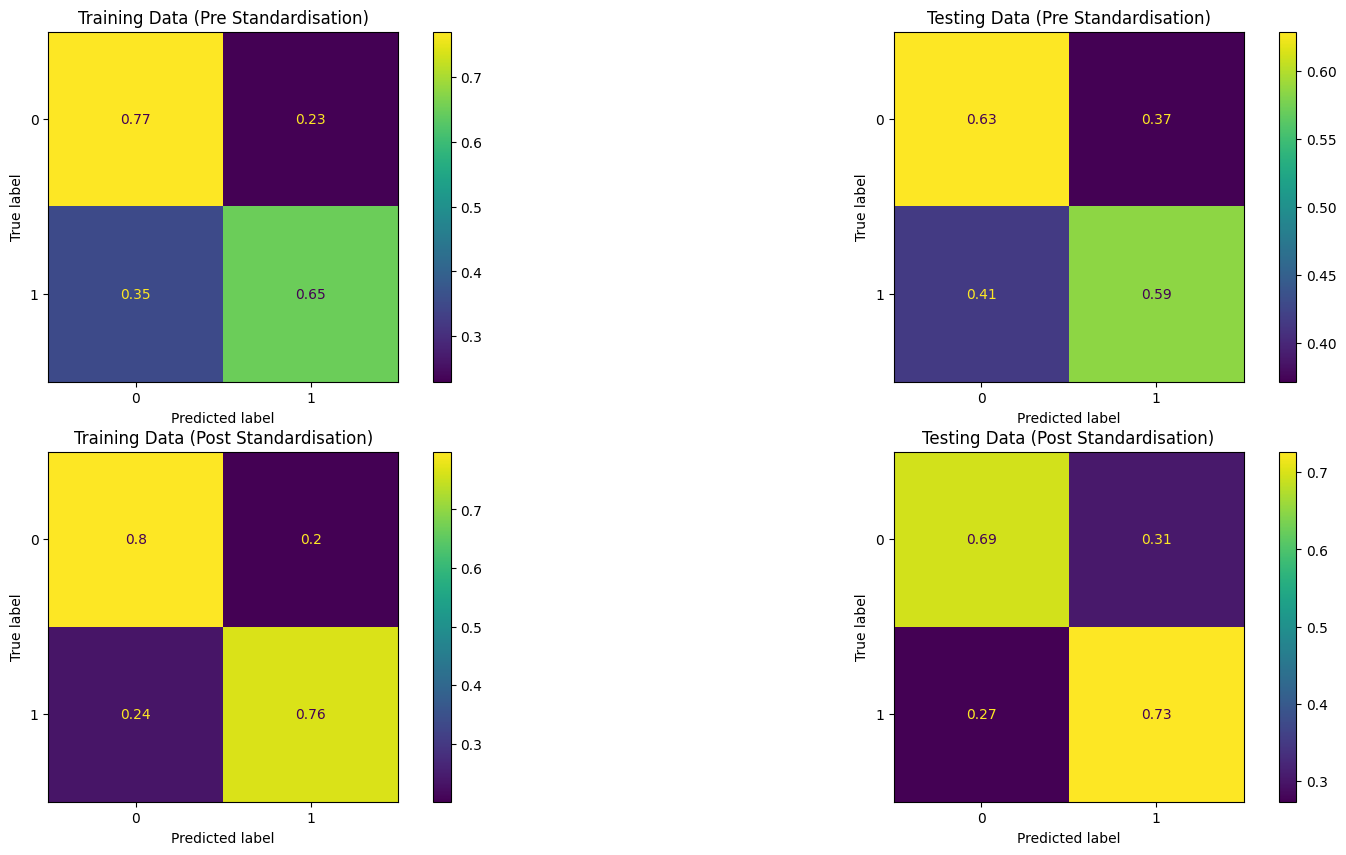

In [215]:
generate_figures([cknn_model, cknn_model_standardised], 4, [X_train, X_test, X_train_standardised, X_test_standardised], [Y_train, Y_test, Y_train_standardised, Y_test_standardised], standardisation_figure_titles)

## Problem 2 - Multi-Class Classification
In this question we are using the multi-class version of the red wine data, redwine-multiclass.csv, which contains fine-grained quality ratings, but is otherwise the same as the binary data. 

Using this data:
* Train a Random Forest to classify a wine's quality. Select appropriate hyper-parameters for the forest, and evaluate the impact of including class weights.
* Train an ensemble of SVMs to predict a wine's quality. In doing this you should:
  * Train both a one vs one and one vs all model. Comment on differences in performance and training speed.
  * Compare the performance of the two models, while also considering the class imbalance in the data. Explore how the error costs can be changed to improve performance for those classes with limited data.
* Obtain precision, recall and F1 score measures for both classifiers, and compare the results.

### Relevant Examples

The second classification example, ``CAB420_Classification_Example_2_Multi_Class_Classification.ipynb`` is a useful starting point here, as that also deals with multi-class classification.

You may also find ``CAB420_Classification_Additional_Example_Classifier_Parameters_and_Decision_Boundaries.ipynb`` useful if you are uncertain on what impacts hyper-parameters have on performance. ``CAB420_Classification_Example_3_Classification_Metrics.ipynb`` contains details on different classification metrics.

### Step 1

Processing here really is the same as Q1. You need to:
* Load the data, I'd suggest pandas and ``read_csv()`` as we've uesd elsewhere
* Pull out X and Y data. Your Y values are the ``quality`` data series
* Split the data into train and test. I'd suggest ``train_test_split`` from ``sklearn.model_selection``, which will split the data into two sets (i.e. split all data into train and test). If you wish to get three datasets (train, validation, and test), then:
  * Split the data into train and "the rest", using say a 70/30 split
  * Split "the rest" into validation and test, using a 50/50 split  

Following this, standarise your data (or not) depending on what you found in Q1. The data is the same as that used in Q1, just with different labels, so if standardisation was helpful there, it will be helpful here.

It's also recommended to explore the class balance. Plot histograms of the y labels and see how balanced (or not) the dataset is.

In [216]:
# Loading the data and showing the first few rows of the multiclass data
redwine_multiclass = pd.read_csv('data/redwine-multiclass.csv')
redwine_multiclass.head()

,fixedAcidity,volatileAcidity,citricAcid,residualSugar,chlorides,freeSulfurDioxide,totalSulfurDioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [217]:
# Splitting the data initially into X and Y
Y = redwine_multiclass['quality']
X = redwine_multiclass.drop(columns = ['quality'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

test_length = len(Y_test)

X_val = X_test[:test_length // 2]
X_test = X_test[test_length // 2:]

Y_val = Y_test[:test_length // 2]
Y_test = Y_test[test_length // 2:]

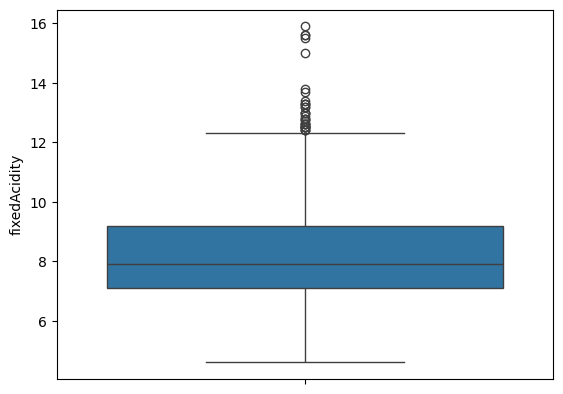

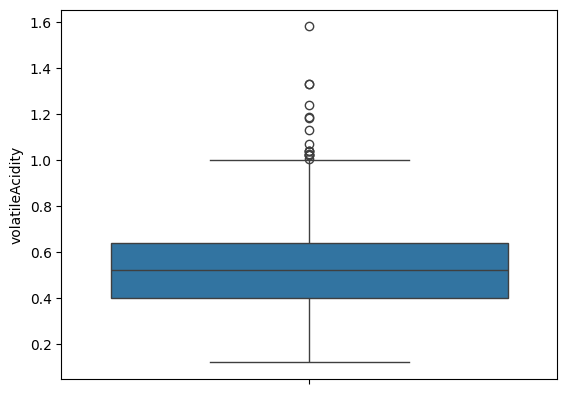

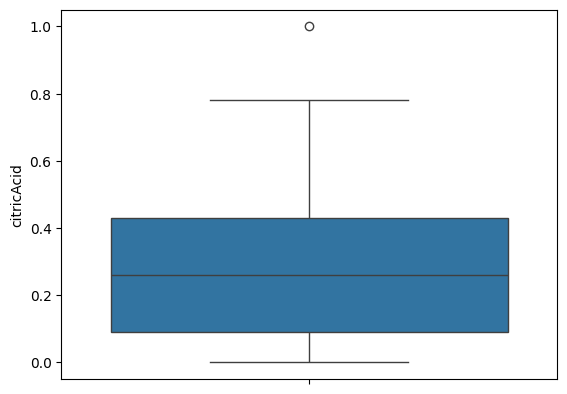

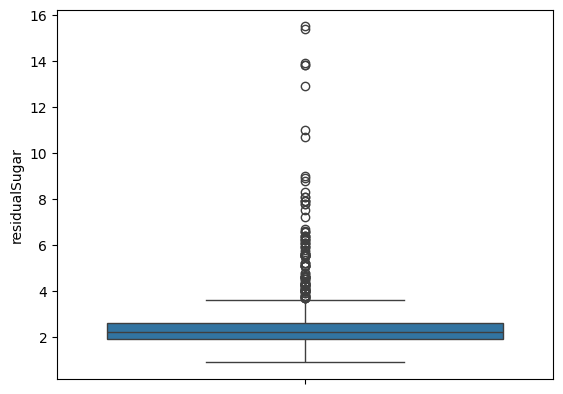

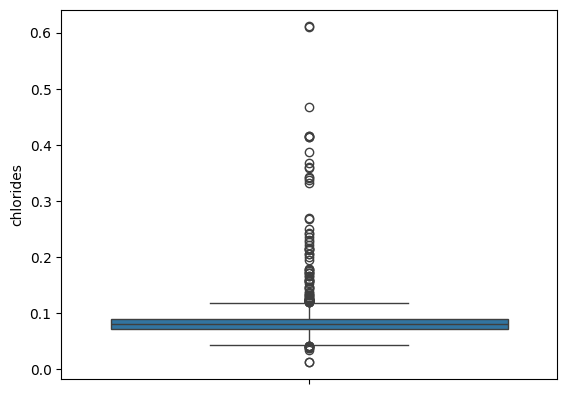

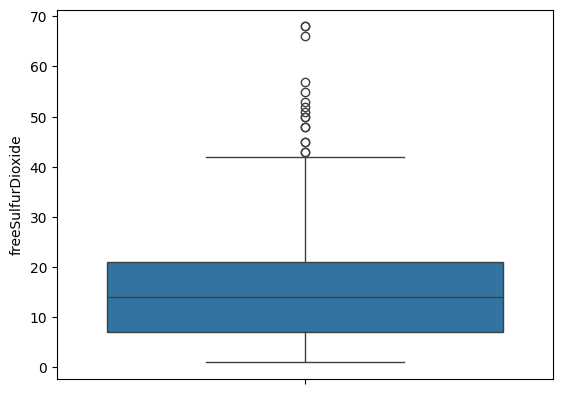

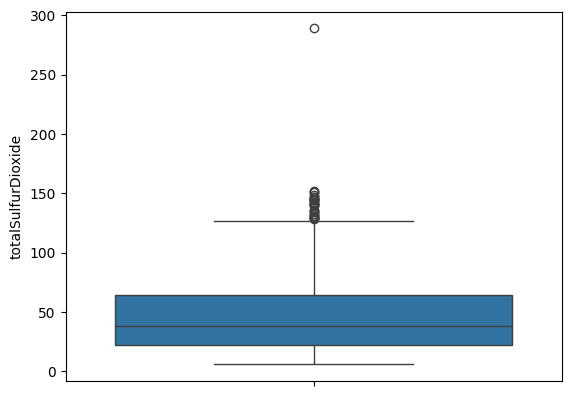

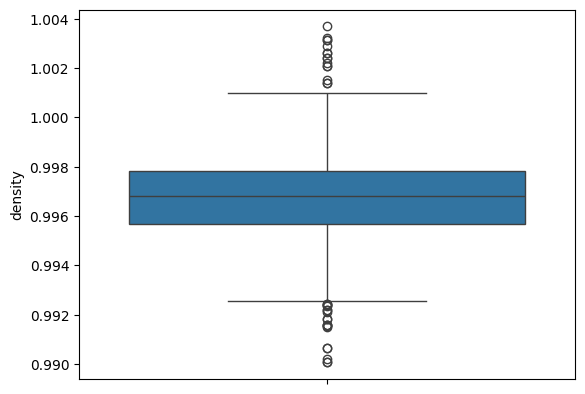

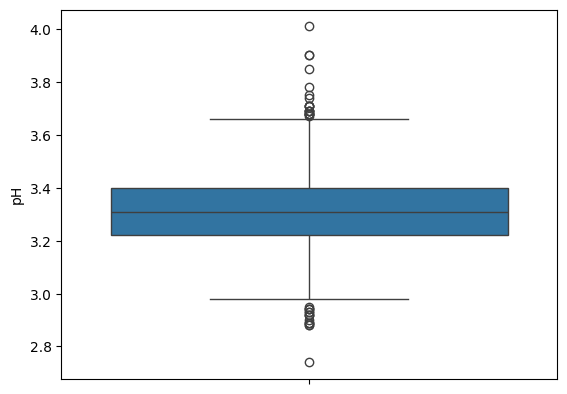

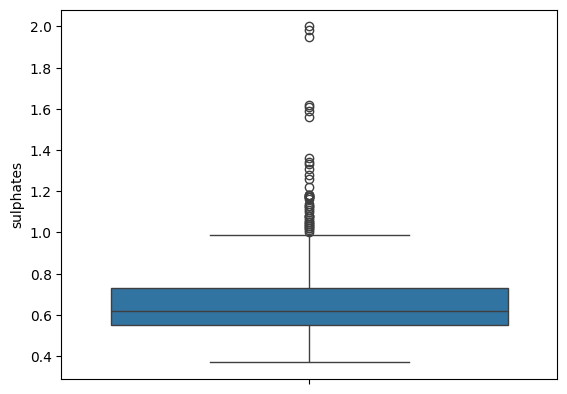

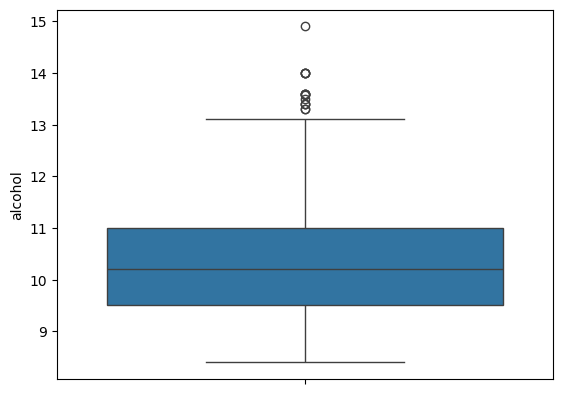

In [218]:
for variable in X_train.columns:
    sns.boxplot(y = X_train[variable])
    plt.show()

Completing the standardisation

In [219]:
mu = np.mean(X_train, 0)
sigma = np.std(X_train, 0)

X_standardised = (X - mu) / sigma

X_train_standardised, X_test_standardised, Y_train_standardised, Y_test_standardised = train_test_split(X_standardised, Y, test_size = 0.3, random_state = 42)

### Step 2: Model Fitting

Here you need to:
* Fit a Random Forest, and explore parameter choices. In particular, focus on tree depth and the number of trees. You are also encouraged to explore what happens as enable class weights. As per Q1, you may use:
  * Simple trial and error
  * A grid search, or similar automated search method. Look at ``CAB420_Classification_Example_1_Classification_Three_Ways.ipynb`` for an example of how to use such methods. More information is also available in the [sklearn documentation](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)
* Fit an SVM, and explore parameter choices. In addition to C and your kernal parameters (type and any kernel specific parameters) experiement with one vs one and one vs all encodings (see ``CAB420_Classification_Example_2_Multi_Class_Classification.ipynb`` for an example of what these look like), and the use of class weights.

An evaluation function is provided below, based on what is used in the lecture examples. When considering performance of methods, consider the overall accuracy as well as precision, recall and F1 score. Note that the provided evaluation function will compute all these.

### Fitting the Random Forest Model

(<Figure size 2000x1000 with 2 Axes>,
 <Axes: title={'center': 'Random Forest'}, xlabel='Predicted label', ylabel='True label'>)

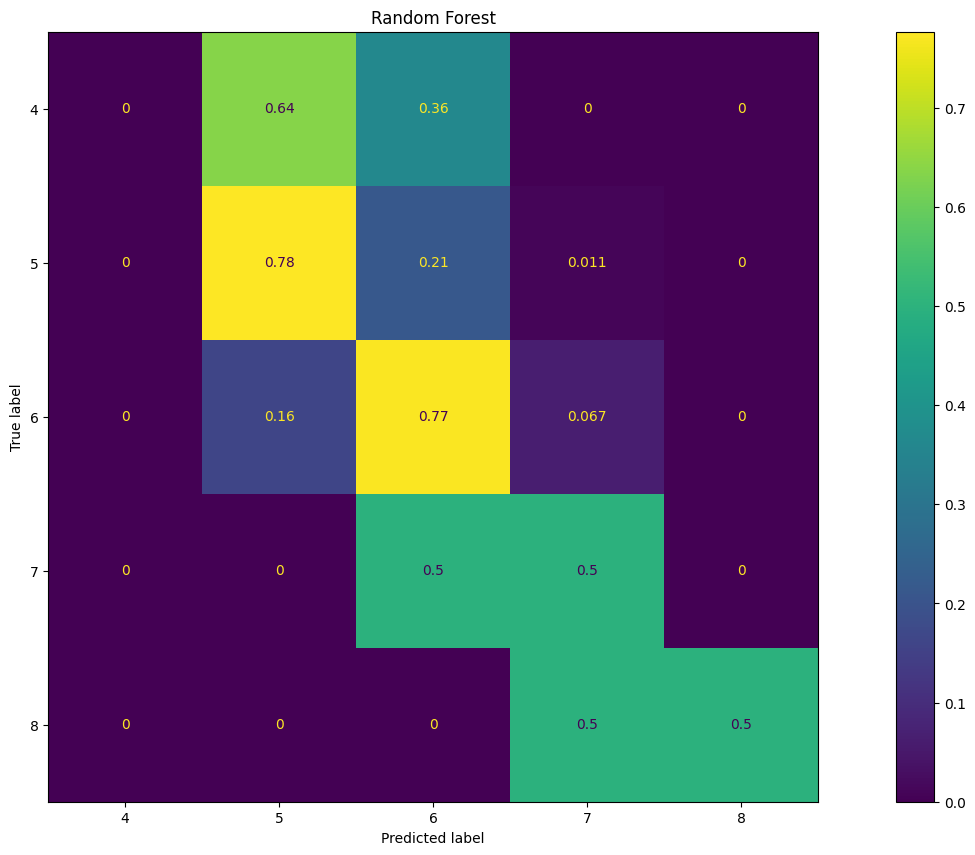

In [228]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 100, random_state = 42)
rf.fit(X_train, Y_train)

generate_figures(rf, 1, [X_test], [Y_test], ['Random Forest'])

### Fitting the Multi Class SVMs
One vs One

(<Figure size 2000x1000 with 2 Axes>,
 <Axes: title={'center': 'One vs One SVM'}, xlabel='Predicted label', ylabel='True label'>)

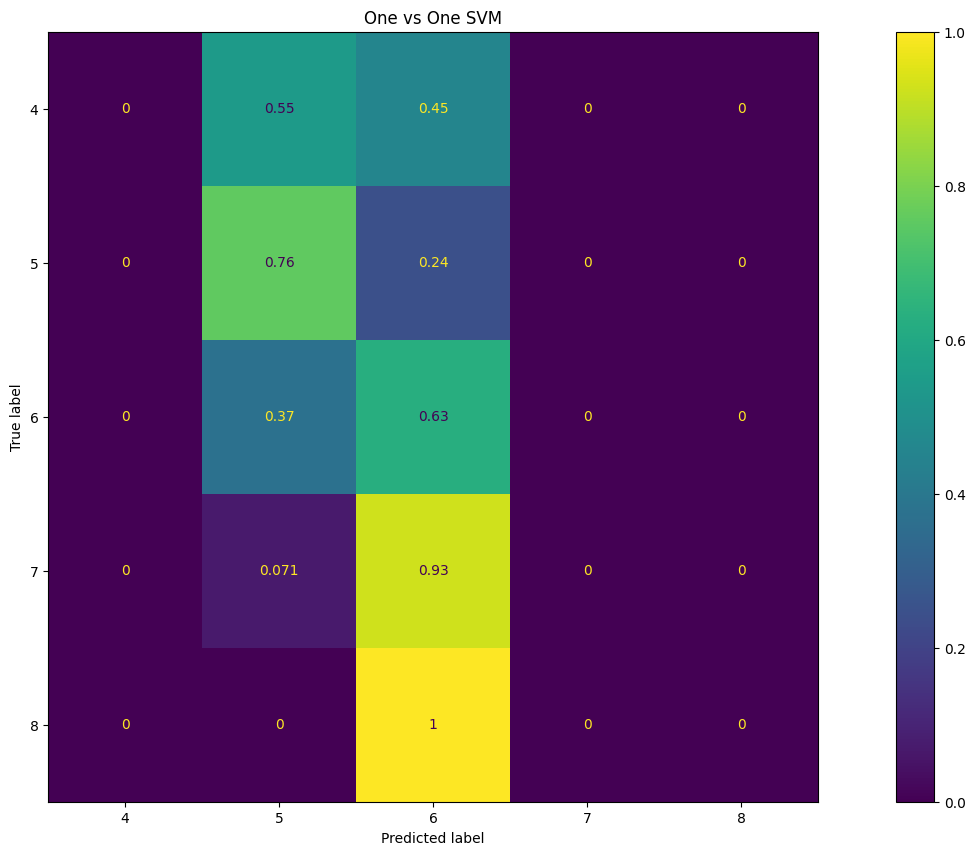

In [ ]:
one_vs_one_svm = OneVsOneClassifier(SVC(C = 1, kernel = 'linear', random_state = 42))
one_vs_one_svm.fit(X_train, Y_train)

generate_figures(one_vs_one_svm, 1, [X_test], [Y_test], ['One vs One SVM'])

One vs Rest

(<Figure size 2000x1000 with 2 Axes>,
 <Axes: title={'center': 'One vs Many SVM'}, xlabel='Predicted label', ylabel='True label'>)

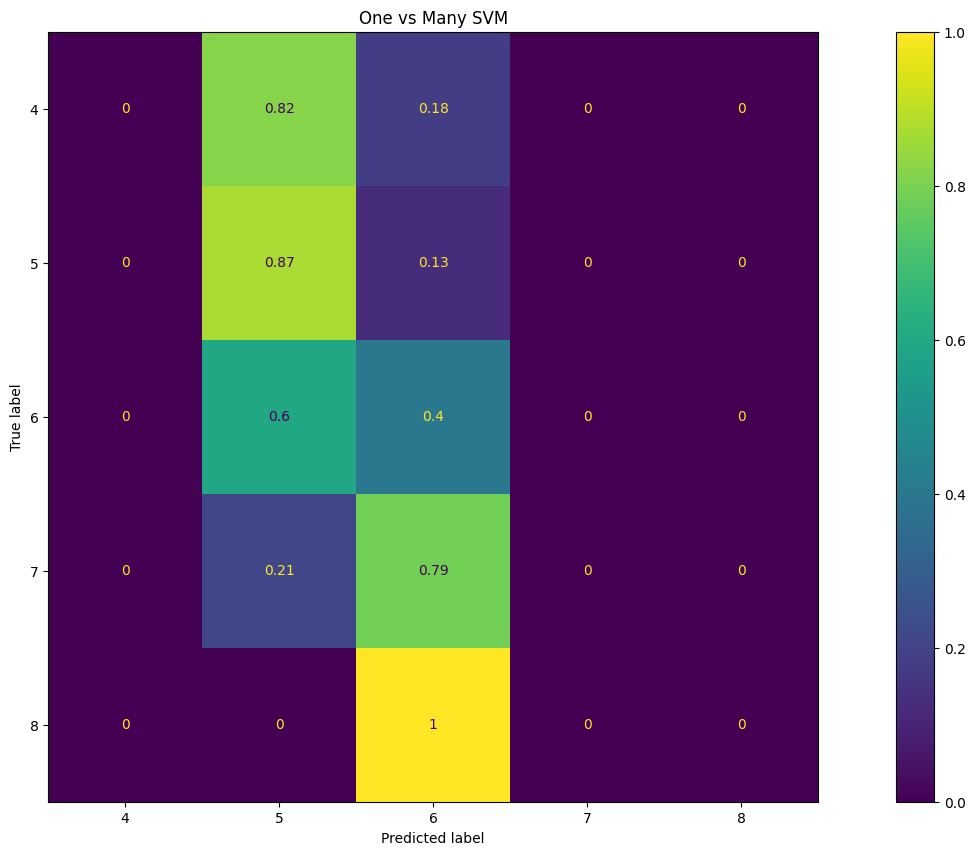

In [240]:
one_vs_many_svm = OneVsRestClassifier(SVC(C = 1, kernel = 'linear', random_state = 42))
one_vs_many_svm.fit(X_train, Y_train)

generate_figures(one_vs_many_svm, 1, [X_test], [Y_test], ['One vs Many SVM'])

### Testing Model Performance after Standardisation
Random Forest Model

In [223]:
rf_model_standardised = RandomForestClassifier(n_estimators = 100, max_depth = 100, random_state = 42)
rf_model_standardised.fit(X_train_standardised, Y_train_standardised)

RandomForestClassifier(max_depth=100, random_state=42)

One vs One and One vs Many SVM

In [224]:
one_vs_one_svm_standardised = OneVsOneClassifier(SVC(C = 50, kernel = 'linear', random_state = 42))
one_vs_one_svm_standardised.fit(X_train_standardised, Y_train_standardised)

one_vs_many_svm_standardised = OneVsRestClassifier(SVC(C = 50, kernel = 'linear', random_state = 42))
one_vs_many_svm_standardised.fit(X_train_standardised, Y_train_standardised)

OneVsRestClassifier(estimator=SVC(C=50, kernel='linear', random_state=42))

### Running Visualisation
Random Forest

(<Figure size 2000x1000 with 8 Axes>,
 <Axes: title={'center': 'Testing Data (Post Standardisation)'}, xlabel='Predicted label', ylabel='True label'>)

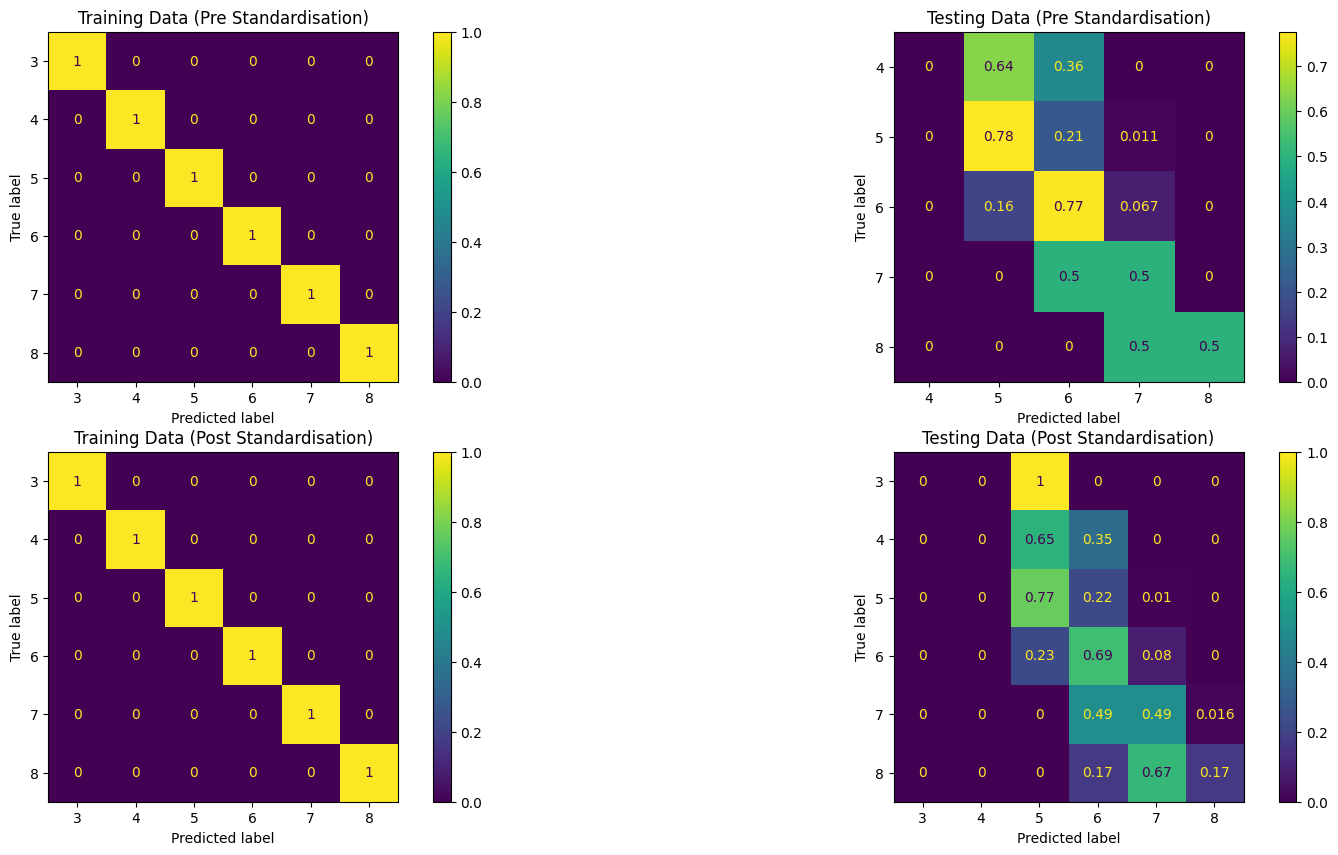

In [239]:
generate_figures([rf, rf_model_standardised], 4, [X_train, X_test, X_train_standardised, X_test_standardised], [Y_train, Y_test, Y_train_standardised, Y_test_standardised], standardisation_figure_titles)

One vs One

(<Figure size 2000x1000 with 8 Axes>,
 <Axes: title={'center': 'Testing Data (Post Standardisation)'}, xlabel='Predicted label', ylabel='True label'>)

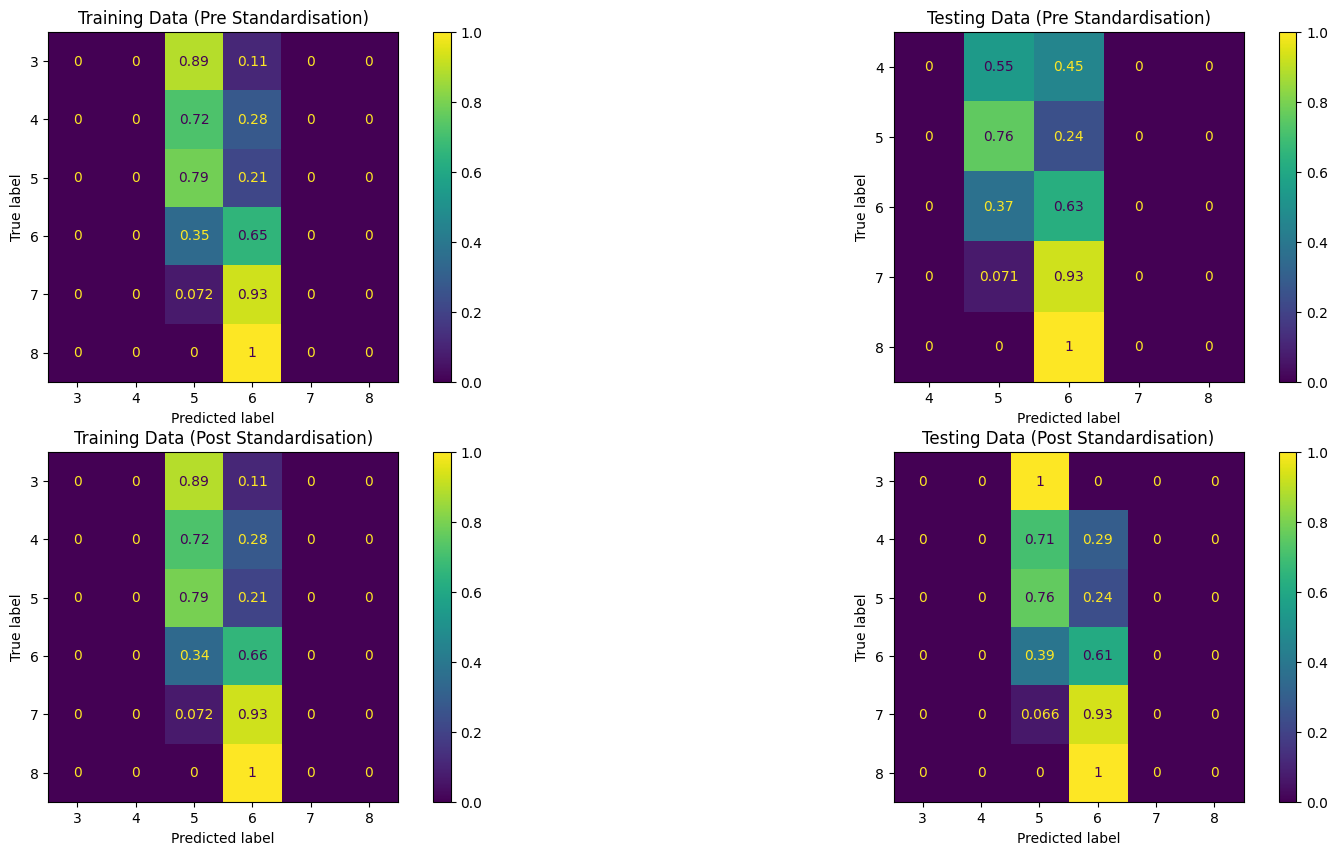

In [238]:
generate_figures([one_vs_one_svm, one_vs_one_svm_standardised], 4, [X_train, X_test, X_train_standardised, X_test_standardised], [Y_train, Y_test, Y_train_standardised, Y_test_standardised], standardisation_figure_titles)

One vs Many

(<Figure size 2000x1000 with 8 Axes>,
 <Axes: title={'center': 'Testing Data (Post Standardisation)'}, xlabel='Predicted label', ylabel='True label'>)

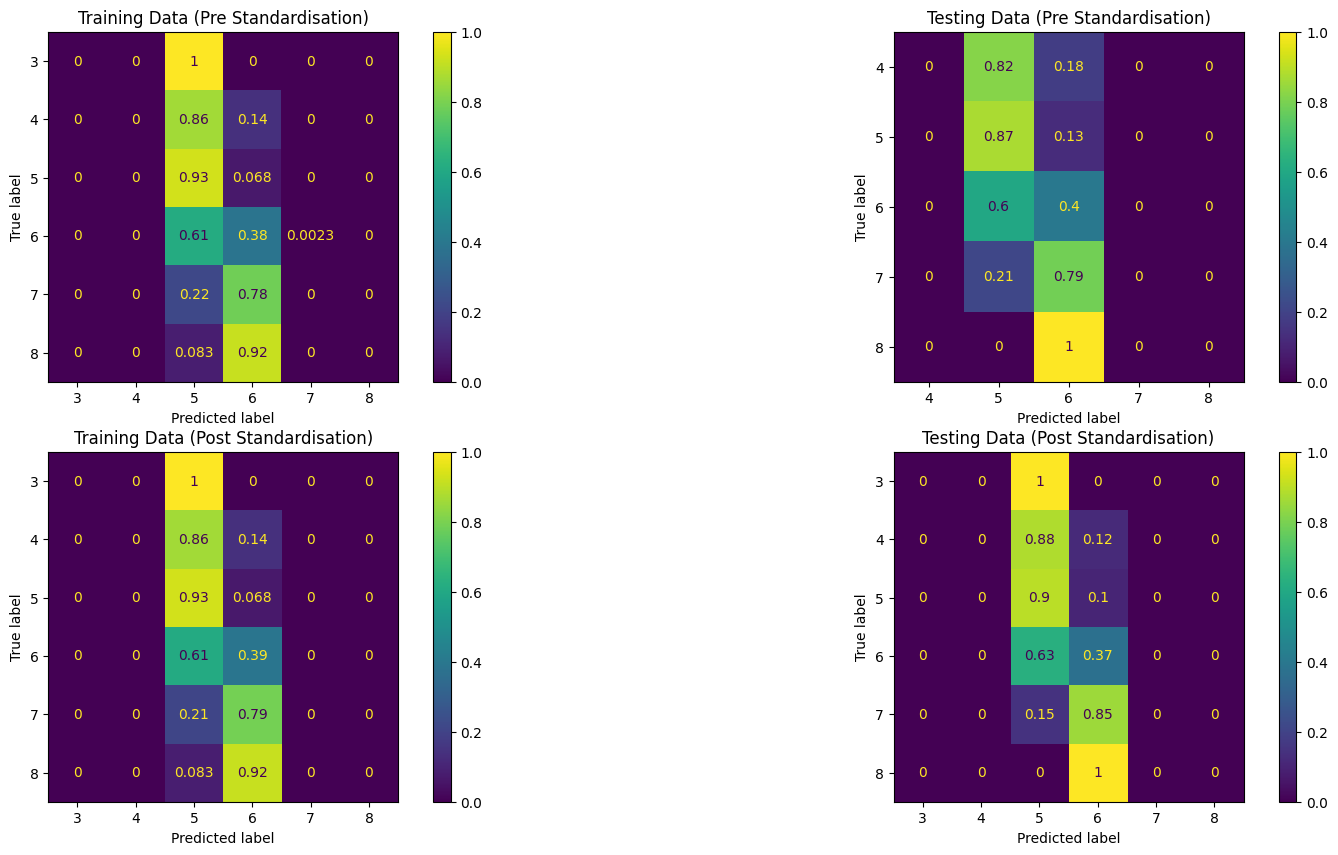

In [237]:
generate_figures([one_vs_many_svm, one_vs_many_svm_standardised], 4, [X_train, X_test, X_train_standardised, X_test_standardised], [Y_train, Y_test, Y_train_standardised, Y_test_standardised], standardisation_figure_titles)